# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



Antes de nada procedo a importar los paquetes y librerías que se van a utilizar en el proyecto:

In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
from google.colab import drive
from scipy.optimize import curve_fit
import seaborn as sns
## Importo las funciones de accuracy y testeo de modelos:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
## Importo los modelos que voy a usar/probar:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
## Librerías de optimización de modelos:
from sklearn.model_selection import RandomizedSearchCV

 Defino una matriz de confusión, es una herramienta muy útil para valorar cómo de bueno es un modelo de clasificación basado en aprendizaje automático.

In [ ]:
def confusion(ytest,y_pred):
    names=["0","1"]
    cm=confusion_matrix(ytest,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [ ]:
#cargamos los datos

drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
root_dir = "/content/gdrive/My Drive/datos_acamica"


Mounted at /content/gdrive


Cargo el dataset.

In [ ]:
datos=pd.read_csv('/content/gdrive/My Drive/datos_acamica/covid-tests-cases-deaths-per-million.csv')
datos

,Entity,Code,Day,total_tests_per_thousand,142605-annotations,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people
0,Afghanistan,AFG,2020-02-24,NaN,NaN,0.126,NaN
1,Afghanistan,AFG,2020-02-25,NaN,NaN,0.126,NaN
2,Afghanistan,AFG,2020-02-26,NaN,NaN,0.126,NaN
3,Afghanistan,AFG,2020-02-27,NaN,NaN,0.126,NaN
4,Afghanistan,AFG,2020-02-28,NaN,NaN,0.126,NaN
...,...,...,...,...,...,...,...
123013,Zimbabwe,ZWE,2021-10-18,NaN,NaN,8770.640,308.637
123014,Zimbabwe,ZWE,2021-10-19,NaN,NaN,8773.092,308.703
123015,Zimbabwe,ZWE,2021-10-20,NaN,NaN,8775.212,308.703
123016,Zimbabwe,ZWE,2021-10-21,NaN,NaN,8782.037,308.902


El método de Pandas, columna.unique devuelve valores únicos en la columna del dataset.

In [ ]:
paises_unicos = datos.Entity.unique()

Obtengo el listado total de paises (sin repeticiones gracias al método unique).

In [ ]:
paises=datos['Entity']

Aquí también obtengo una lista con el total de casos confirmados de covid por millón de personas.

In [ ]:
confirmados=datos['Total confirmed cases of COVID-19 per million people'] 

In [ ]:
datos.describe()

,total_tests_per_thousand,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people
count,5.533200e+04,121292.000000,110331.000000
mean,4.722185e+05,18552.701439,384.708988
std,1.150691e+06,31176.242930,640.878392
min,0.000000e+00,0.001000,0.000000
25%,2.186800e+04,380.533000,11.170000
50%,1.098475e+05,2960.828500,75.072000
75%,4.371308e+05,22931.788000,478.885000
max,1.601323e+07,223455.667000,5995.399000


In [ ]:
# Chequeo valores faltantes:

nombre_columnas_ = datos.columns # Me armo un vector con los nombres de las columnas
bool_mat = datos.isna()
tamaño_con_nans = datos.shape

print('----------')
print('datos')
print('----------')
print('Tamaño de datos: ',tamaño_con_nans)
print('----------')

faltantes = []
for nombre in nombre_columnas_: # Voy iterando el nombre del vector nombre_columnas con un for.
  print('Falantes en: ',nombre,': ',sum(bool_mat[nombre]),' valores.')
  faltantes.append(sum(bool_mat[nombre]))

----------
datos
----------
Tamaño de datos:  (123018, 7)
----------
Falantes en:  Entity :  0  valores.
Falantes en:  Code :  9020  valores.
Falantes en:  Day :  0  valores.
Falantes en:  total_tests_per_thousand :  67686  valores.
Falantes en:  142605-annotations :  69301  valores.
Falantes en:  Total confirmed cases of COVID-19 per million people :  1726  valores.
Falantes en:  Total confirmed deaths due to COVID-19 per million people :  12687  valores.


Text(0, 0.5, 'cantidad de casos')

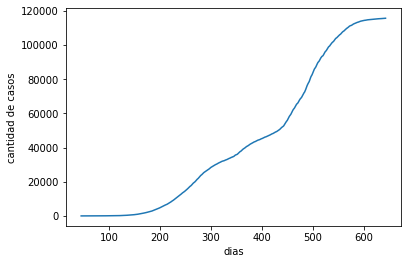

In [ ]:
ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias=np.arange(0,len(casos_arg))
plt.plot(dias,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de la Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

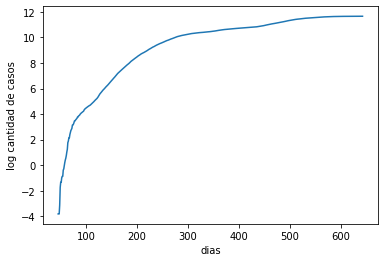

In [ ]:
plt.plot(dias,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

Text(0, 0.5, 'cantidad de casos')

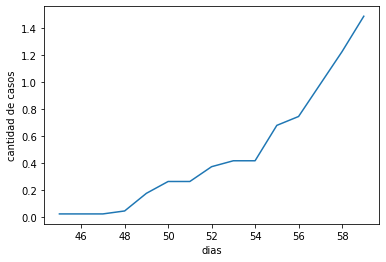

In [ ]:
casos_principio=casos_arg[0:60]
dias_principio=dias[0:60]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

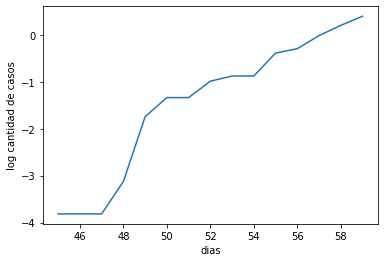

In [ ]:

plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 31 y 55, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

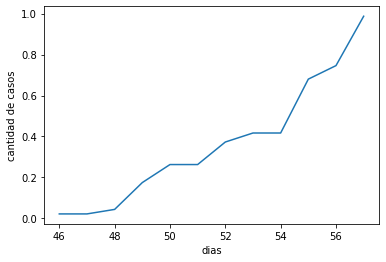

In [ ]:
casos_principio=casos_arg[46:58]
dias_principio=dias[46:58]

plt.plot(dias_principio,casos_principio)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

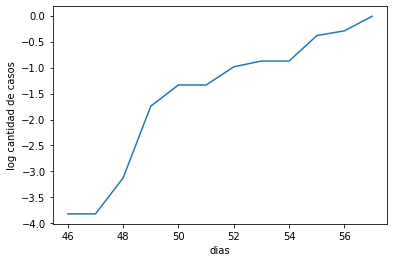

In [ ]:
plt.plot(dias_principio,np.log(casos_principio))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [ ]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [ ]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)
popt

array([ 0.23093272, 57.06239595])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

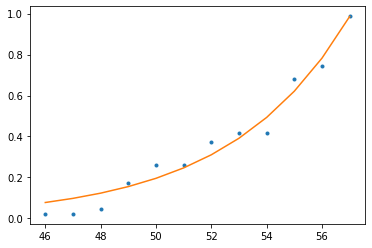

In [ ]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)
plt.plot(dias_principio,casos_principio,'.')
plt.plot(dias_principio,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [ ]:
def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos   

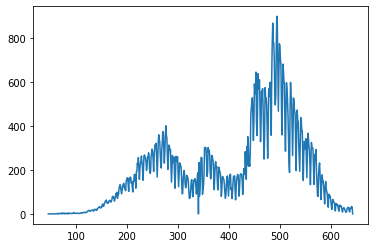

In [ ]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos(casos_arg)
plt.plot(nuevos_arg)

#PARTE 1.

###Voy a visualizar los gráficos de a uno y luego todos juntos, para sacar a mano un intervalo de días confiable y así sacar el k.

SUECIA

Text(0, 0.5, 'cantidad de casos')

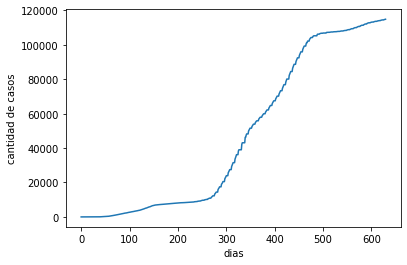

In [ ]:
ind_swe=np.where(paises=='Sweden')
ind_swe=ind_swe[0]
casos_swe=confirmados[ind_swe]
dias=np.arange(0,len(casos_swe))
plt.plot(dias,casos_swe)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

NORUEGA

Text(0, 0.5, 'cantidad de casos')

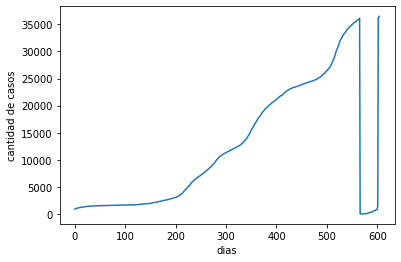

In [ ]:
ind_norw=np.where(paises=='Norway')
ind_norw=ind_norw[0]
casos_norw=confirmados[ind_norw]
dias=np.arange(0,len(casos_norw))
plt.plot(dias,casos_norw)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

CANADÁ

Text(0, 0.5, 'cantidad de casos')

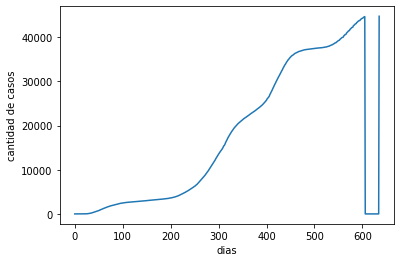

In [ ]:
ind_can=np.where(paises=='Canada')
ind_can=ind_can[0]
casos_can=confirmados[ind_can]
dias=np.arange(0,len(casos_can))
plt.plot(dias,casos_can)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

RUSIA

Text(0, 0.5, 'cantidad de casos')

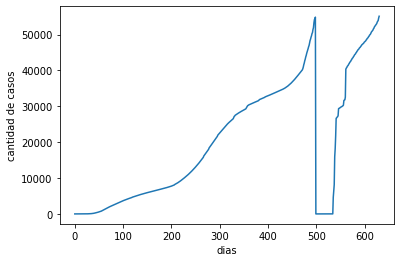

In [ ]:
ind_rus=np.where(paises=='Russia')
ind_rus=ind_rus[0]
casos_rus=confirmados[ind_rus]
dias=np.arange(0,len(casos_rus))
plt.plot(dias,casos_rus)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

DINAMARCA

Text(0, 0.5, 'cantidad de casos')

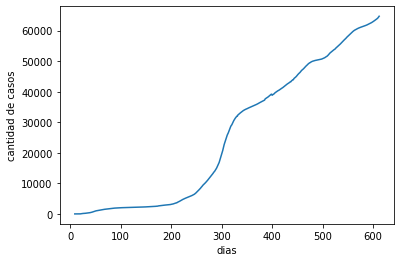

In [ ]:
ind_den=np.where(paises=='Denmark')
ind_den=ind_den[0]
casos_den=confirmados[ind_den]
dias=np.arange(0,len(casos_den))
plt.plot(dias,casos_den)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

IRLANDA

Text(0, 0.5, 'cantidad de casos')

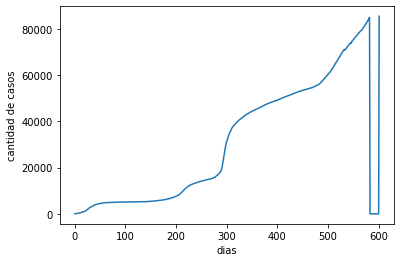

In [ ]:
ind_ire=np.where(paises=='Ireland')
ind_ire=ind_ire[0]
casos_ire=confirmados[ind_ire]
dias=np.arange(0,len(casos_ire))
plt.plot(dias,casos_ire)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

ESPAÑA

Text(0, 0.5, 'cantidad de casos')

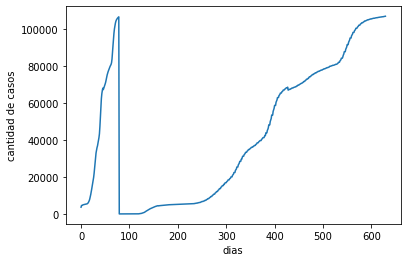

In [ ]:
ind_esp=np.where(paises=='Spain')
ind_esp=ind_esp[0]
casos_esp=confirmados[ind_esp]
dias=np.arange(0,len(casos_esp))
plt.plot(dias,casos_esp)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

CROACIA

Text(0, 0.5, 'cantidad de casos')

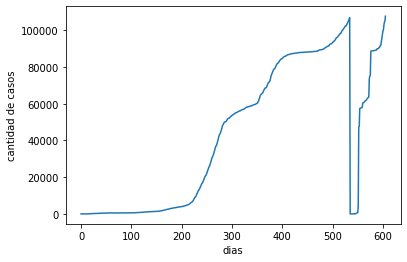

In [ ]:
ind_cro=np.where(paises=='Croatia')
ind_cro=ind_cro[0]
casos_cro=confirmados[ind_cro]
dias=np.arange(0,len(casos_cro))
plt.plot(dias,casos_cro)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

FRANCIA

Text(0, 0.5, 'cantidad de casos')

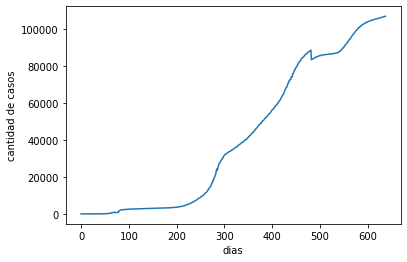

In [ ]:
ind_fra=np.where(paises=='France')
ind_fra=ind_fra[0]
casos_fra=confirmados[ind_fra]
dias=np.arange(0,len(casos_fra))
plt.plot(dias,casos_fra)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

ISRAEL

Text(0, 0.5, 'cantidad de casos')

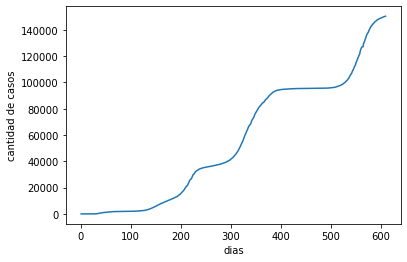

In [ ]:
ind_isr=np.where(paises=='Israel')
ind_isr=ind_isr[0]
casos_isr=confirmados[ind_isr]
dias=np.arange(0,len(casos_isr))
plt.plot(dias,casos_isr)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

##  1.A) Voy a armarme las curvas de casos $Confirmados=e^{k(t-t_0)}$ por millón, para los 10 países que elegí.

Trato de responderme la pregunta: 
¿Es posible estimar el comportamiento de la curva exponencial de contagios por millón de habitantes mundial, con la información obtenida de los ritmos de contagios de los países seleccionados?

In [ ]:
## Elección de cortes de días para los distitnos países:
data_2 = pd.read_csv('/content/gdrive/My Drive/datos_acamica/covid-tests-cases-deaths-per-million.csv')
paises = ['Canada', 'Croatia', 'Denmark','France', 'Ireland', 'Israel','Norway','Russia', 'Spain', 'Sweden', 'World']
data_2_select = data_2[(data_2['Entity'].isin(paises))]
data_2_world  = data_2[(data_2['Entity'].isin(['World']))]

Código que manifiesta todos juntos, los países que vimos en los gráficos más arriba.

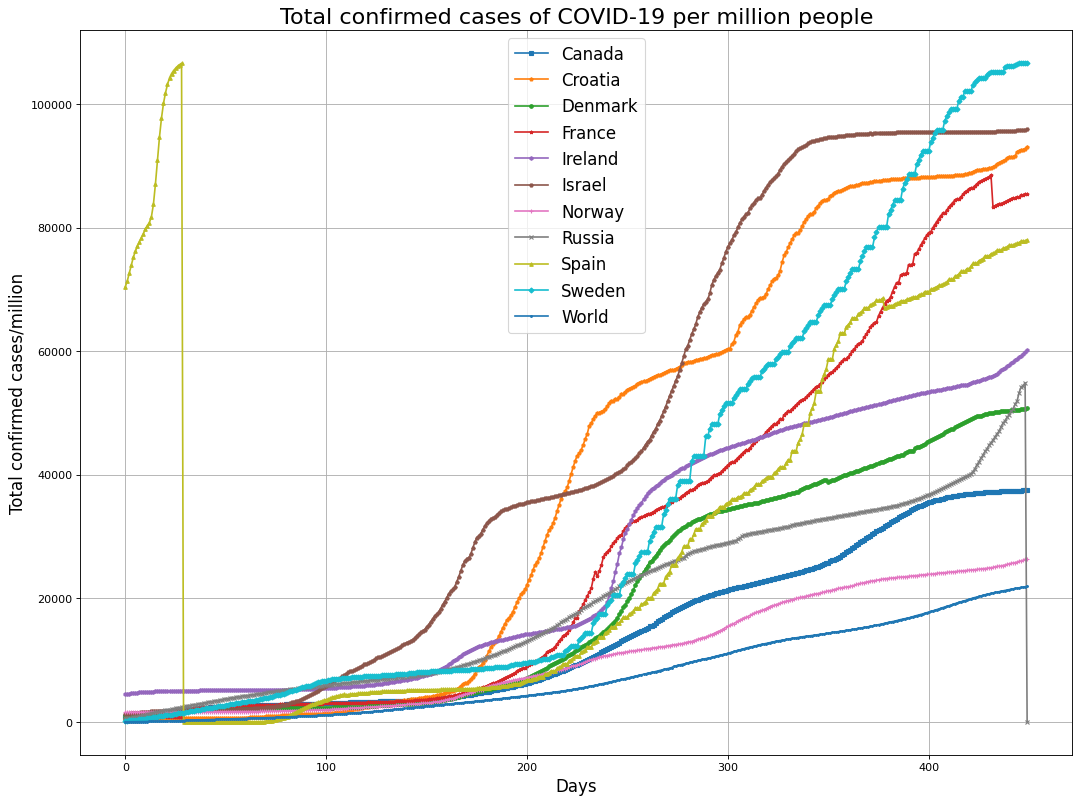

In [ ]:
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x","^","D",".","*"]

for pais in paises:
   casos_pais = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == pais)][50:500]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Total confirmed cases of COVID-19 per million people', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed cases/million', fontsize = 15)
plt.xlabel('Days', fontsize = 15)
plt.grid()
plt.show() 

Aquí se tiene en cuenta los datos a escala mundial.

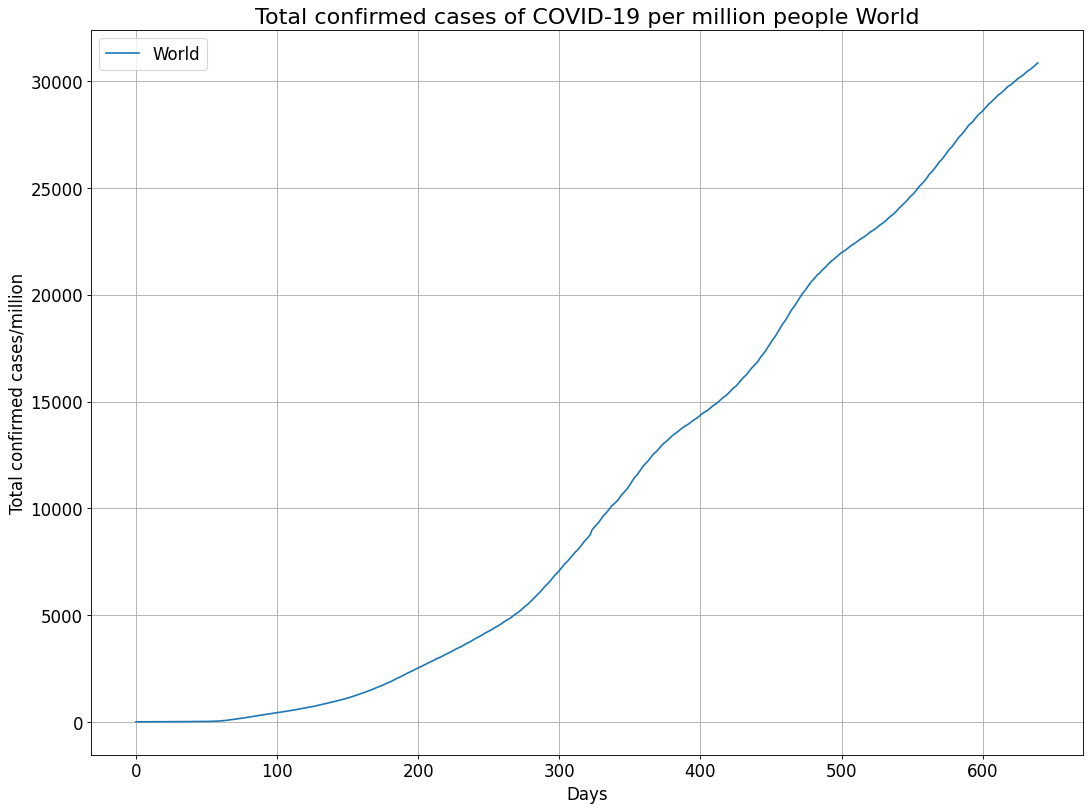

In [ ]:
casos_world = data_2_world['Total confirmed cases of COVID-19 per million people']
dias = np.arange(casos_world.shape[0]) 

plt.figure(figsize=(8*scale, 6*scale), dpi=80)
plt.plot(dias,casos_world, label = 'World')
plt.title('Total confirmed cases of COVID-19 per million people World', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed cases/million', fontsize = 15)
plt.xlabel('Days', fontsize = 15)
plt.grid()
plt.show()

### ESTOS SON LOS INTERVALOS DEFINITIVOS DE DÍAS POR PAÍS QUE DECIDÍ TOMAR VIENDO LAS GRÁFICAS:

In [ ]:
d_canada     = np.arange(200,301)
d_croatia    = np.arange(180,281)
d_denmark    = np.arange(160,261)
d_france     = np.arange(180,281)
d_ireland    = np.arange(110,211)
d_israel     = np.arange(125,226)
d_norway     = np.arange(150,251)
d_russia     = np.arange(20,121)
d_spain      = np.arange(200,301)
d_sweden     = np.arange(200,301)
d_world      = np.arange(200,301)

In [ ]:
## Correr las K.

casos_canada = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Canada')][200:301]
casos_croatia = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Croatia')][180:281]
casos_denmark = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Denmark')][160:261]
casos_france = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'France')][180:281]
casos_ireland = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Ireland')][110:211]
casos_israel = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Israel')][125:226]
casos_norway = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Norway')][150:251]
casos_russia = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Russia')][20:121]
casos_spain = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Spain')][200:301]
casos_sweden = data_2_select['Total confirmed cases of COVID-19 per million people'][(data_2_select.Entity == 'Sweden')][200:301]
casos_world  = data_2_world['Total confirmed cases of COVID-19 per million people'][(data_2_world.Entity == 'World')][200:301]

In [ ]:
#Ajustamos para cada país:

popt_1, pcov_1 = curve_fit(exponencial, d_canada, casos_canada, maxfev = 1000)
popt_2, pcov_2 = curve_fit(exponencial, d_denmark , casos_denmark, maxfev = 2000)
popt_3, pcov_3 = curve_fit(exponencial, d_france, casos_france, maxfev = 1000)
popt_4, pcov_4 = curve_fit(exponencial, d_ireland, casos_ireland, maxfev = 2000)
popt_5, pcov_5 = curve_fit(exponencial, d_israel, casos_israel, maxfev = 1000)
popt_6, pcov_6 = curve_fit(exponencial, d_croatia, casos_croatia, maxfev = 1000)
popt_7, pcov_7 = curve_fit(exponencial, d_norway, casos_norway, maxfev = 2000)
popt_8, pcov_8 = curve_fit(exponencial, d_russia, casos_russia, maxfev = 1000)
popt_9, pcov_9 = curve_fit(exponencial, d_spain, casos_spain, maxfev = 2000)
popt_10, pcov_10 = curve_fit(exponencial, d_sweden, casos_sweden, maxfev = 1000)
popt_11, pcov_11 = curve_fit(exponencial, d_world , casos_world, maxfev = 2000)

In [ ]:
k = [popt_1[0],popt_2[0],popt_3[0],popt_4[0],popt_5[0],popt_6[0],popt_7[0],popt_8[0],popt_9[0],popt_10[0]] # K optimos
k_world = popt_11[0]

Este es el resultado obtenido para la escala global

In [ ]:
k_world

0.009979911357953303

Este es el resultado obtenido para cada uno de los países, lo que se observa a simple vista son valores de k muy variados entre sí

In [ ]:
k  # Tenemos las k de los 10 países

## Pais - Indice inicio - Indice Fin - k 
# ANDORRA. 200                301.      0.0230

[0.014483953414605802,
 0.014674422971935313,
 0.022262711255441135,
 0.0054869412647030255,
 0.021991427770391408,
 0.0295989359131208,
 0.015298515888513295,
 0.024812024783402026,
 0.015565010226229335,
 0.012551816574562837]

 ## BOOTSTRAP:

El bootstrapping (o bootstrap) es un método de remuestreo. Se utiliza para aproximar la distribución en el muestreo de un estadístico. Se usa frecuentemente para aproximar el sesgo o la varianza de un análisis estadístico, así como para construir intervalos de confianza o realizar contrastes de hipótesis sobre parámetros de interés. En la mayor parte de los casos no pueden obtenerse expresiones cerradas para las aproximaciones bootstrap y por lo tanto es necesario obtener remuestras en un ordenador para poner a prueba el método. La enorme potencia de cálculo de los ordenadores actuales facilita considerablemente la aplicabilidad de este método tan costoso computacionalmente.

In [ ]:
## Boot strap:

def remuestreo(datos):
  remuestra=np.zeros(len(datos))
  i=0
  while i<len(datos):
    remuestra[i]=datos[np.random.randint(len(datos))]
    i=i+1
  return remuestra  

(array([3., 0., 0., 2., 1., 0., 3., 0., 0., 1.]),
 array([0.00548694, 0.00789814, 0.01030934, 0.01272054, 0.01513174,
        0.01754294, 0.01995414, 0.02236534, 0.02477654, 0.02718774,
        0.02959894]),
 <a list of 10 Patch objects>)

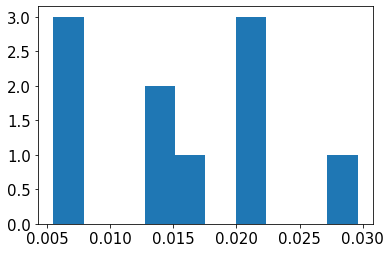

In [ ]:
datos_rem=remuestreo(k)
plt.hist(datos_rem)

0.017425480771989278


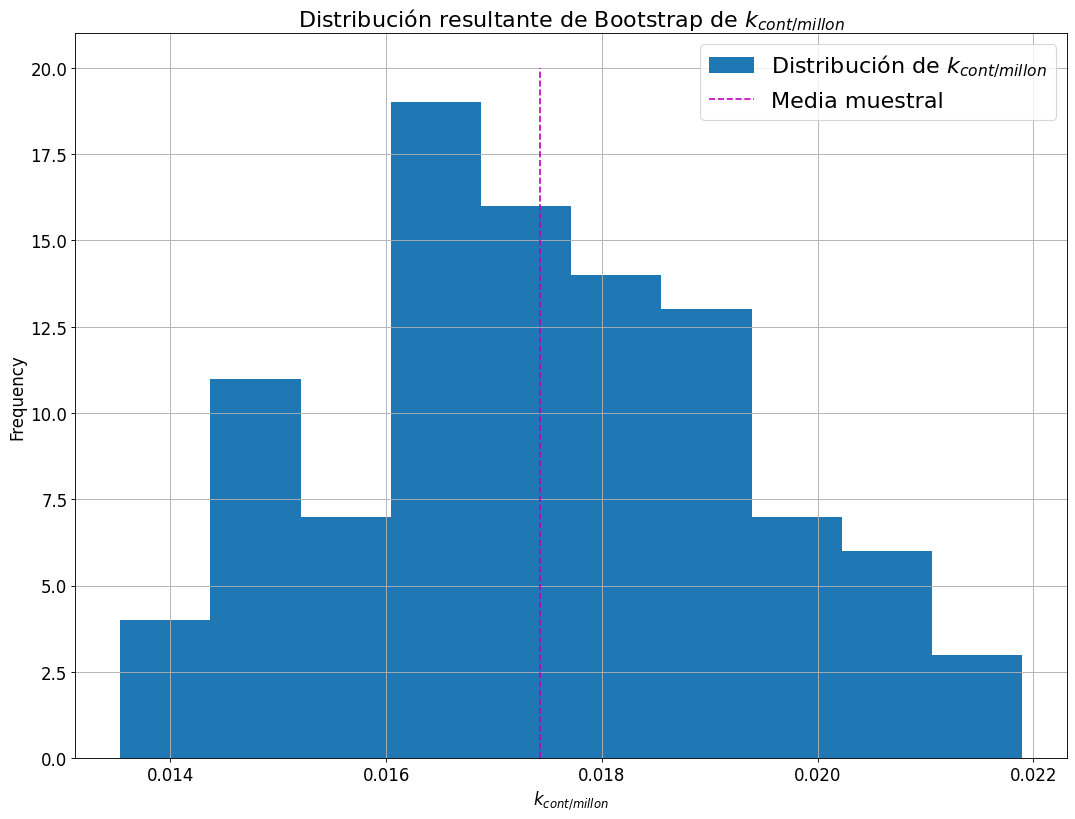

In [ ]:
# Bootstrap:

np.random.seed(8) # Elegir semilla.
nrep = 100
datos_100 = k # Tenemos las k de los 10 países
medias = []

for i in np.arange(nrep):
  datos_rem=remuestreo(datos_100)
  medias.append(np.mean(datos_rem))

mu_muestra    = np.mean(medias)
sigma_muestra = np.std(medias)
print(np.mean(medias))

plt.figure(figsize=(8*scale, 6*scale), dpi=80)
plt.hist(medias, histtype = 'stepfilled',label = 'Distribución de $k_{cont/millon}$')
plt.vlines(mu_muestra, 0, 20, colors='m', linestyles='dashed', label="Media muestral")
plt.title('Distribución resultante de Bootstrap de $k_{cont/millon}$', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('$k_{cont/millon}$', fontsize = 15)
plt.legend(fontsize = 20)
plt.grid()
plt.show()


En este caso si  α=0.05 , corresponde  zaplha=1.96 . Esto se logra saber haciendo uso primero de la fórmula y luego con el resultado, se usa la tabla de valores que nos da el valor definitivo que tendra zalpha.

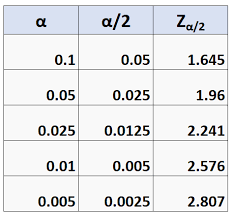

In [ ]:
## Intervalo de conf:
z=1.96
n=len(medias)
int_conf=[mu_muestra-z*sigma_muestra/np.sqrt(n),mu_muestra+z*sigma_muestra/np.sqrt(n)]
print(int_conf)
# Calcular el p valor.

[0.01705226712718583, 0.017798694416792726]


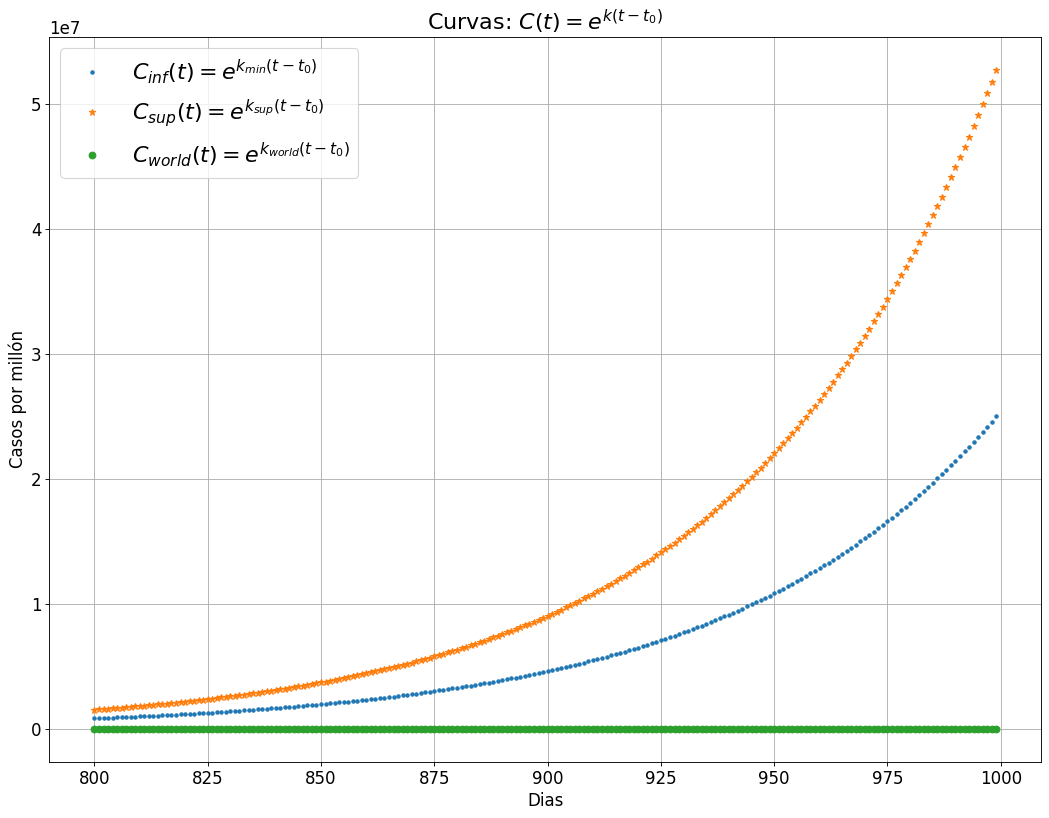

In [ ]:
# Graficos de curvas:
k_min = int_conf[0]
k_max = int_conf[1]
k_mundo = k_world

dias_principio = np.arange(800,1000)

casos_simu_min=exponencial(dias_principio,k_min,0)
casos_simu_max=exponencial(dias_principio,k_max,0)
casos_simu_world=exponencial(dias_principio,k_mundo,0)

plt.figure(figsize=(8*scale, 6*scale), dpi=80)
plt.plot(dias_principio,casos_simu_min,'.', label = '$C_{inf}(t)=e^{k_{min}(t-t_0)}$')
plt.plot(dias_principio,casos_simu_max,'*', label = '$C_{sup}(t)=e^{k_{sup}(t-t_0)}$')
plt.plot(dias_principio,casos_simu_world,'o', label = '$C_{world}(t)=e^{k_{world}(t-t_0)}$')
plt.title('Curvas: $C(t)=e^{k(t-t_0)}$',fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.xlabel('Dias',fontsize = 15)
plt.ylabel('Casos por millón',fontsize = 15)
plt.legend(fontsize = 20)
plt.grid()
plt.show()

##**El k del mundo no cae dentro del intervalo de confianza. Eso se da porque los intervalos de dias que tomamos, representan intervalos de C(t) con K muy variables entre países respecto de una vurva de C(t) que se ve mas suavizada para los casos mundiales.**

Estos paises tuvieron una cuarentena diferenciada a los anteriores ya que adoptaron una política de cuarentena màs corta.

In [ ]:
paises_0 = ['Brazil','Uruguay','Ireland','Sweden','Greece','Finland','Denmark','Dominican Republic','Canada','Nicaragua']


Países que tuvieron una cuarentena extremadamente larga, tomados de distintas partes del mundo. 

In [ ]:
paises_1 = ['Bolivia','Colombia','France','Guatemala','Honduras','India','Argentina','Norway','Panama','Peru'] 

In [ ]:
 all_paises = ['Brazil','Uruguay','Ireland','Sweden','Greece','Finland','Denmark','Dominican Republic','Canada','Nicaragua',
              'Bolivia','Colombia','France','Guatemala','Honduras','India','Argentina','Norway','Panama','Peru']

Para diferenciar unos paises de otros les otorgo un número a cada uno, el numero (1) para los paises que tuvieron la cuarentena más larga, y el numero (0) para los que tuvieron la cuarentena más corta.

In [ ]:
cuarentena = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]

# Mis estadísticos van a ser:
  k de muertes por millon: k_deths_mil

---


 k de contagios por millon: k_ill_mil


---


 ratio muertes = muertes/casos confirmados.

In [ ]:
data_3 = pd.read_csv('/content/gdrive/My Drive/datos_acamica/covid-tests-cases-deaths-per-million.csv')
data_3.head()

,Entity,Code,Day,total_tests_per_thousand,142605-annotations,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people
0,Afghanistan,AFG,2020-02-24,NaN,NaN,0.126,NaN
1,Afghanistan,AFG,2020-02-25,NaN,NaN,0.126,NaN
2,Afghanistan,AFG,2020-02-26,NaN,NaN,0.126,NaN
3,Afghanistan,AFG,2020-02-27,NaN,NaN,0.126,NaN
4,Afghanistan,AFG,2020-02-28,NaN,NaN,0.126,NaN


In [ ]:
# Armo el data set vacío con todos los países:
dat = {'Pais': all_paises, 'k_deaths_mil': np.zeros(len(all_paises)), 'k_ill_mil': np.zeros(len(all_paises)), 'ratio_deaths_cases': np.zeros(len(all_paises)),'target': cuarentena}  
data_ml = pd.DataFrame(dat)
data_ml

,Pais,k_deaths_mil,k_ill_mil,ratio_deaths_cases,target
0,Brazil,0.0,0.0,0.0,0
1,Uruguay,0.0,0.0,0.0,0
2,Ireland,0.0,0.0,0.0,0
3,Sweden,0.0,0.0,0.0,0
4,Greece,0.0,0.0,0.0,0
5,Finland,0.0,0.0,0.0,0
6,Denmark,0.0,0.0,0.0,0
7,Dominican Republic,0.0,0.0,0.0,0
8,Canada,0.0,0.0,0.0,0
9,Nicaragua,0.0,0.0,0.0,0


In [ ]:
cases = 'Total confirmed cases of COVID-19 per million people'
deaths = 'Total confirmed deaths due to COVID-19 per million people'

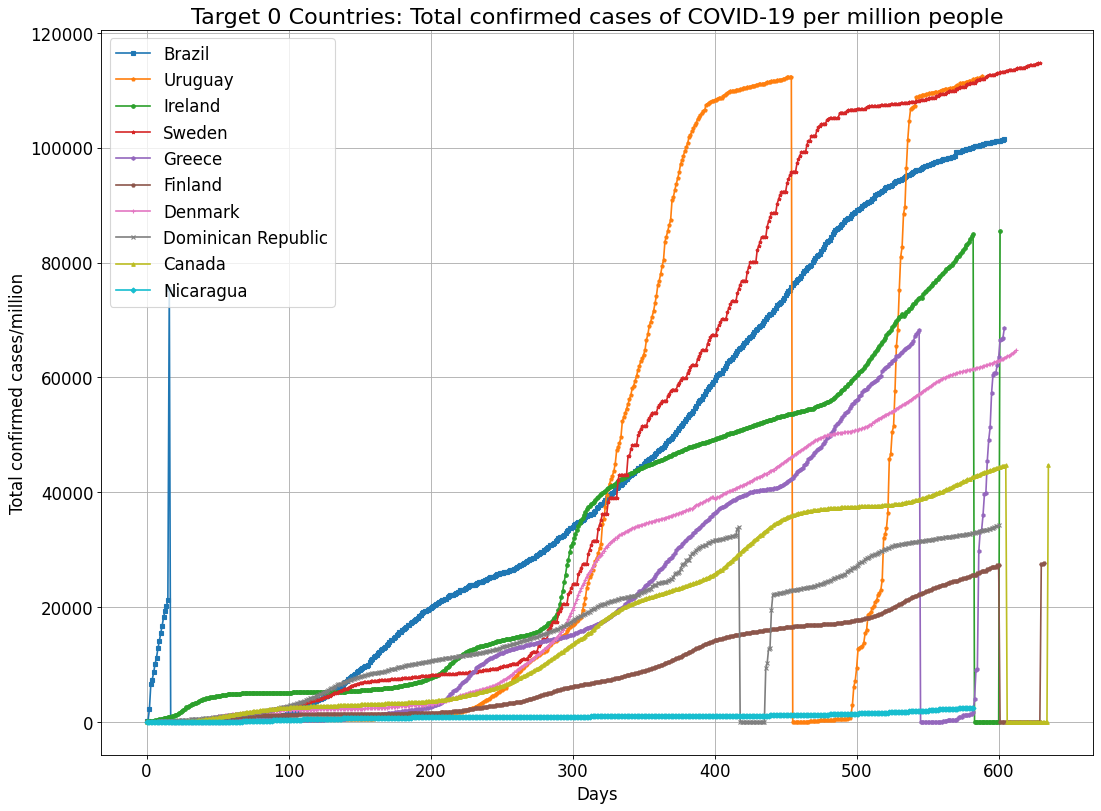

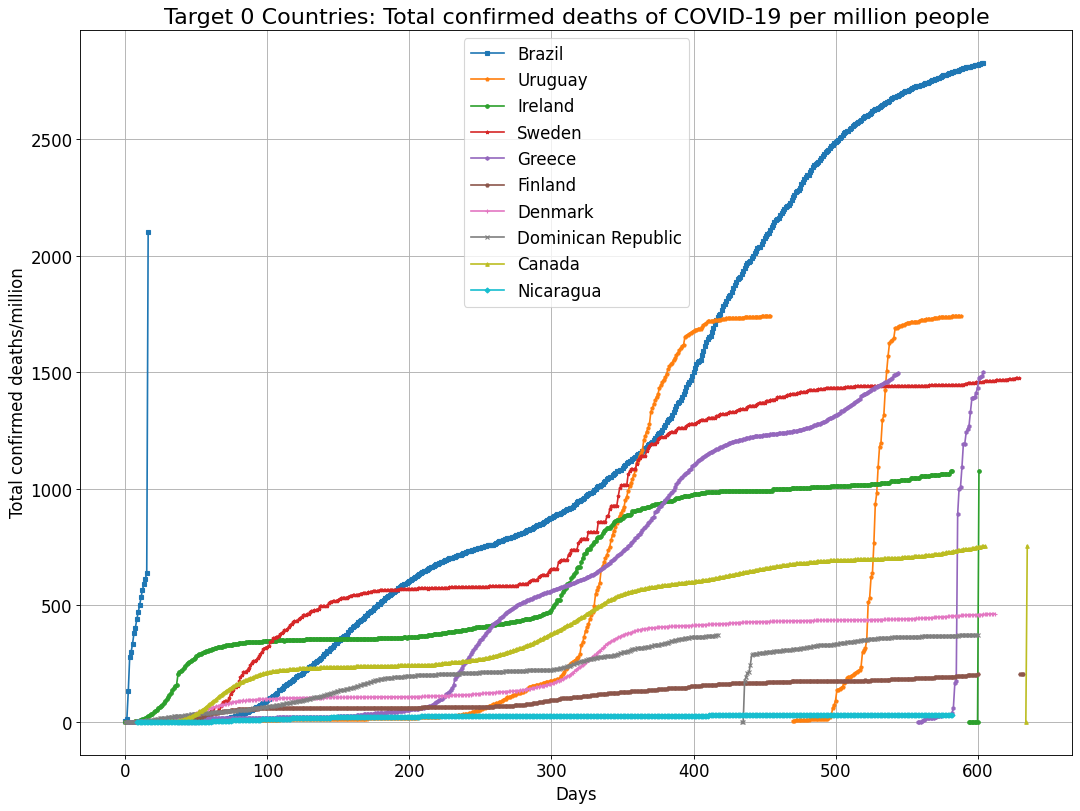

In [ ]:
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x","^","D","*"]

for pais in paises_0:
   casos_pais = data_3[cases][(data_3.Entity == pais)]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Target 0 Countries: Total confirmed cases of COVID-19 per million people', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed cases/million', fontsize = 15)
plt.xlabel('Days', fontsize = 15)
plt.grid()
plt.show()

# Muertes:
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x","^","D","*"]

for pais in paises_0:
   muertes_pais = data_3[deaths][(data_3.Entity == pais)]
   dias = np.arange(muertes_pais.shape[0]) 
   plt.plot(dias,muertes_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Target 0 Countries: Total confirmed deaths of COVID-19 per million people', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed deaths/million', fontsize = 15)
plt.xlabel('Days', fontsize = 15)
plt.grid()
plt.show()

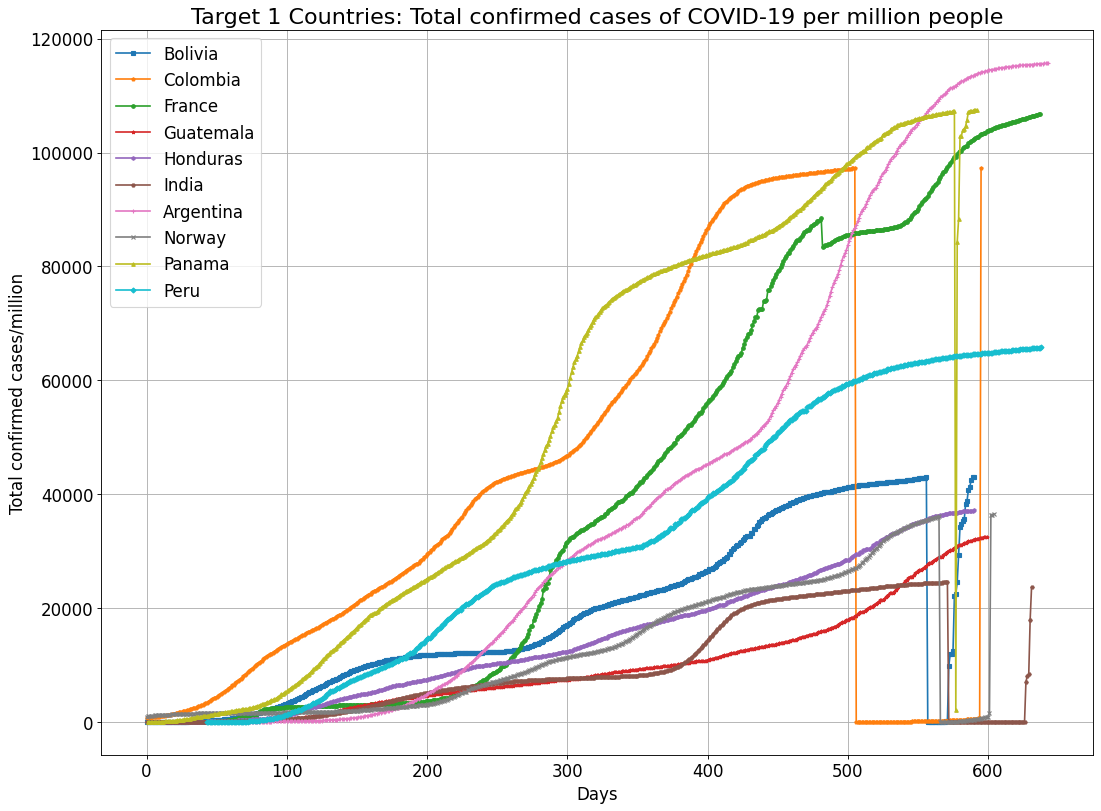

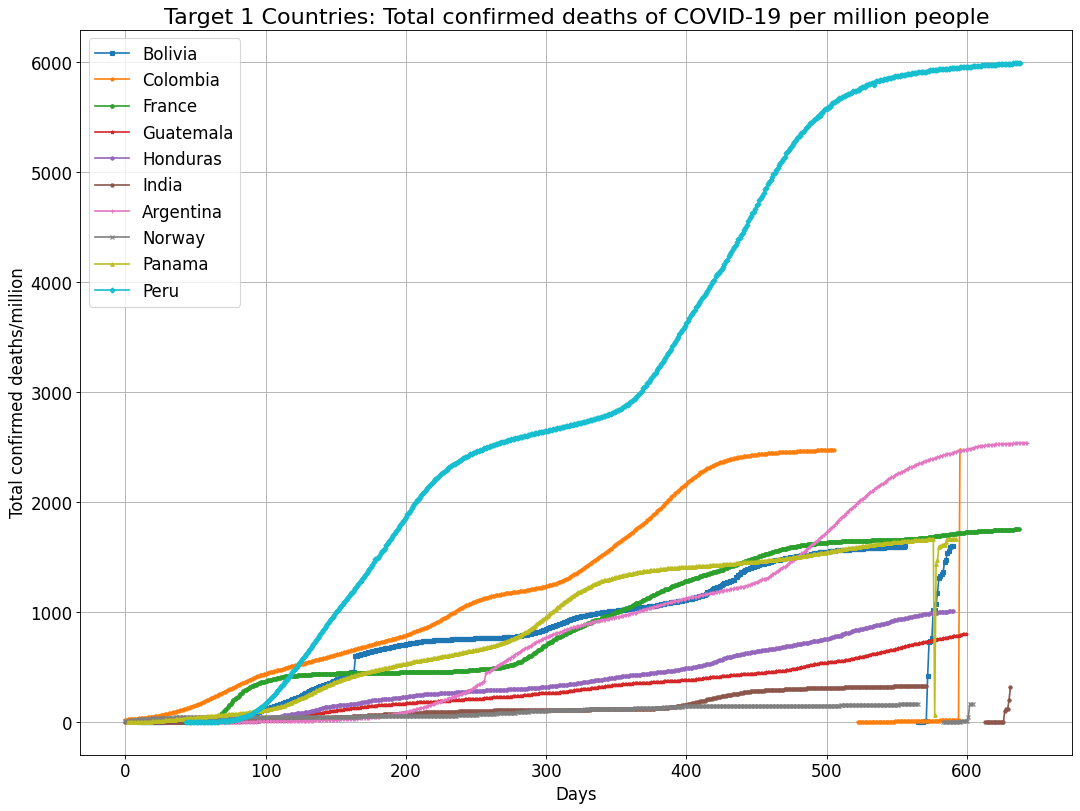

In [ ]:
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x","^","D","*"]

for pais in paises_1:
   casos_pais = data_3[cases][(data_3.Entity == pais)]
   dias = np.arange(casos_pais.shape[0]) 
   plt.plot(dias,casos_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Target 1 Countries: Total confirmed cases of COVID-19 per million people', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed cases/million', fontsize = 15)
plt.xlabel('Days', fontsize = 15)
plt.grid()
plt.show()

# Muertes:
i = 0
scale = 2
plt.figure(figsize=(8*scale, 6*scale), dpi=80)
marks = ["s","p","o","*","h","H","+","x","^","D","*"]

for pais in paises_1:
   muertes_pais = data_3[deaths][(data_3.Entity == pais)]
   dias = np.arange(muertes_pais.shape[0]) 
   plt.plot(dias,muertes_pais,label = pais, marker = marks[i], markersize = 3.2)
   i = i + 1

plt.title('Target 1 Countries: Total confirmed deaths of COVID-19 per million people', fontsize = 20)
plt.rc('axes', labelsize =10)
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)
plt.legend(fontsize = 15)
plt.ylabel('Total confirmed deaths/million', fontsize = 15)
plt.xlabel('Days', fontsize = 15)
plt.grid()
plt.show()

## Exploratioria de charts de muertes y casos de países que no hiciero cuarentena:
 La idea es ver en que intervalo de dias tomar los datos tanto para casos como para muertes
 y ver que comportamiento tiene la curva de muertes: Expoencial u otra.

- **Por convenciencia voy a tomar el mismo intervalo de días: 200 a 400. De los puntos anteriores, este parece ser el promedio común de comportamiento exponencial de ambas curvas, tanto la de muertes por millon como la de contagios, que respomden a estos modelos:**

- $Contagios=e^{k illMil(t-t_0)}$
- $Muertes=e^{k deaths(t-t_0)}$

## Unificando el dataset para el modelo de ML:

In [ ]:
data_ml.head()

,Pais,k_deaths_mil,k_ill_mil,ratio_deaths_cases,target
0,Brazil,0.0,0.0,0.0,0
1,Uruguay,0.0,0.0,0.0,0
2,Ireland,0.0,0.0,0.0,0
3,Sweden,0.0,0.0,0.0,0
4,Greece,0.0,0.0,0.0,0


In [ ]:
all_paises

['Brazil',
 'Uruguay',
 'Ireland',
 'Sweden',
 'Greece',
 'Finland',
 'Denmark',
 'Dominican Republic',
 'Canada',
 'Nicaragua',
 'Bolivia',
 'Colombia',
 'France',
 'Guatemala',
 'Honduras',
 'India',
 'Argentina',
 'Norway',
 'Panama',
 'Peru']

In [ ]:
intervalo     = np.arange(200,401)

In [ ]:
casos_bra = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Brazil')][200:401]
casos_uru = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Uruguay')][200:401]
casos_ire = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Ireland')][200:401]
casos_swe = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Sweden')][200:401]
casos_gree = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Greece')][200:401]
casos_fin = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Finland')][200:401]
casos_den = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Denmark')][200:401]
casos_domi = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Dominican Republic')][200:401]
casos_canada = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Canada')][200:401]
casos_nica = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Nicaragua')][200:401]
casos_boli  = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Bolivia')][200:401]
casos_col = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Colombia')][200:401]
casos_fra = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'France')][200:401]
casos_gua = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Guatemala')][200:401]
casos_hond = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Honduras')][200:401]
casos_ind = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'India')][200:401]
casos_arg = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Argentina')][200:401]
casos_nor = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Norway')][200:401]
casos_pana  = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Panama')][200:401]
casos_per  = data_3['Total confirmed cases of COVID-19 per million people'][(data_3.Entity == 'Peru')][200:401]

In [ ]:
de_bra = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Brazil')][200:401]
de_uru = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Uruguay')][200:401]
de_ire = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Ireland')][200:401]
de_swe = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Sweden')][200:401]
de_gree = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Greece')][200:401]
de_fin = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Finland')][200:401]
de_den = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Denmark')][200:401]
de_domi = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Dominican Republic')][200:401]
de_canada = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Canada')][200:401]
de_nica = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Nicaragua')][200:401]
de_boli  = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Bolivia')][200:401]
de_col = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Colombia')][200:401]
de_fra = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'France')][200:401]
de_gua = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Guatemala')][200:401]
de_hond = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Honduras')][200:401]
de_ind = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'India')][200:401]
de_arg = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Argentina')][200:401]
de_nor = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Norway')][200:401]
de_pana  = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Panama')][200:401]
de_per  = data_2_select['Total confirmed deaths due to COVID-19 per million people'][(data_2_select.Entity == 'Peru')][200:401]

In [ ]:
popt_c1, pcov_c1 = curve_fit(exponencial, intervalo, casos_bra, maxfev = 2000)
popt_c2, pcov_c2 = curve_fit(exponencial, intervalo, casos_uru, maxfev = 2000)
popt_c3, pcov_c3 = curve_fit(exponencial, intervalo, casos_gree, maxfev = 2000)
popt_c4, pcov_c4 = curve_fit(exponencial, intervalo, casos_swe, maxfev = 2000)
popt_c5, pcov_c5 = curve_fit(exponencial, intervalo, casos_domi, maxfev = 2000)
popt_c6, pcov_c6 = curve_fit(exponencial, intervalo, casos_fin, maxfev = 2000)
popt_c7, pcov_c7 = curve_fit(exponencial, intervalo, casos_den, maxfev = 2000)
popt_c8, pcov_c8 = curve_fit(exponencial, intervalo, casos_nica, maxfev = 2000)
popt_c9, pcov_c9 = curve_fit(exponencial, intervalo, casos_boli, maxfev = 2000)
popt_c10, pcov_c10 = curve_fit(exponencial, intervalo, casos_canada, maxfev = 2000)
popt_c11, pcov_c11 = curve_fit(exponencial, intervalo, casos_col, maxfev = 2000)
popt_c12, pcov_c12 = curve_fit(exponencial, intervalo, casos_fra, maxfev = 2000)
popt_c13, pcov_c13 = curve_fit(exponencial, intervalo, casos_gua, maxfev = 2000)
popt_c14, pcov_c14 = curve_fit(exponencial, intervalo, casos_hond, maxfev = 2000)
popt_c15, pcov_c15 = curve_fit(exponencial, intervalo, casos_ind, maxfev = 2000)
popt_c16, pcov_c16 = curve_fit(exponencial, intervalo, casos_arg, maxfev = 2000)
popt_c17, pcov_c17 = curve_fit(exponencial, intervalo, casos_nor, maxfev = 2000)
popt_c18, pcov_c18 = curve_fit(exponencial, intervalo, casos_pana, maxfev = 2000)
popt_c19, pcov_c19 = curve_fit(exponencial, intervalo, casos_per, maxfev = 2000)
popt_c20, pcov_c20 = curve_fit(exponencial, intervalo, casos_ire, maxfev = 2000)

In [ ]:
paises = all_paises
i = 0
for pais in paises:
    casos_pais = data_3[cases][(data_3.Entity == pais)][200:401]
    muertes_pais = data_3[deaths][(data_3.Entity == pais)][200:401]
    ratio_muertes_casos = np.mean(muertes_pais)/np.mean(casos_pais)
    dias = np.arange(200,401) 
    popt_casos , pcov_casos  = curve_fit(exponencial, dias, casos_pais, maxfev = 2000)       # Fiteo las exponenciales de casos.
    popt_muert , pcov_muert  = curve_fit(exponencial, dias, muertes_pais, maxfev = 2000)     # Fiteo las exponenciales de muertes.
    # Inserto los datos al df que voy a usar para hacer el modelo:
    data_ml.loc[i,('k_ill_mil')]          =  popt_casos[0]
    data_ml.loc[i,('k_deaths_mil')]       =  popt_muert[0]
    data_ml.loc[i,('ratio_deaths_cases')] =  ratio_muertes_casos
    i = i + 1

In [ ]:
# Data final:
data_ml = data_ml.sample(frac=1).reset_index(drop=True) # Hago un shuffle.
data_ml

,Pais,k_deaths_mil,k_ill_mil,ratio_deaths_cases,target
0,Greece,0.987636,0.992506,0.031207,0
1,Finland,0.987295,0.992084,0.015259,0
2,Peru,0.994464,0.991910,0.096995,1
3,Panama,0.994068,0.993682,0.017477,1
4,Sweden,0.994612,0.994821,0.026440,0
5,Uruguay,0.992983,0.991677,0.013606,0
6,Nicaragua,0.993791,0.988372,0.027311,0
7,Norway,0.988223,0.988082,0.008214,1
8,Canada,0.993122,0.994663,0.029078,0
9,Ireland,0.988900,0.989750,0.021197,0


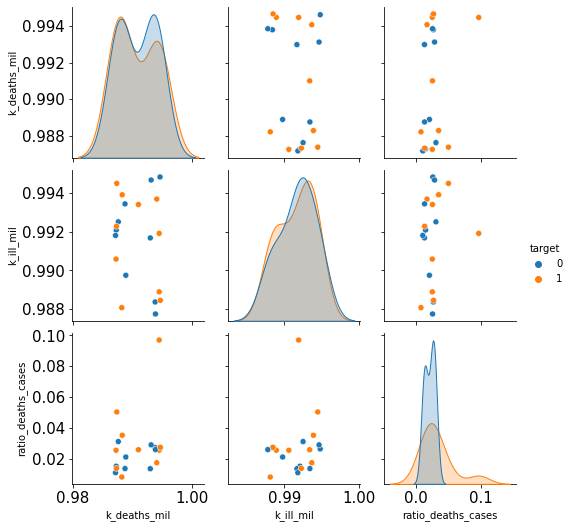

In [ ]:
sns.pairplot(data=data_ml[['k_deaths_mil'	,'k_ill_mil',	'ratio_deaths_cases',	'target']],hue = 'target')

# MACHINE LEARNING:


1.   A continuación van a ver un modelo de machine learning de clasificación.
2.   Voy a usar regresión logística y Naive Bayes.

Para medir el modelo voy a setear el accuracy en un 50%, para que los resultados se diga que fueron óptimos necesito obtener de 50% para arriba.


In [ ]:
## Separo mi data en X e y:
X = data_ml[['k_deaths_mil','k_ill_mil','ratio_deaths_cases']]
y = data_ml[['target']] # Paises que hicieron cuarentena: 1, Paises que no hicieron cuarentena: 0.

## Separo en train y test:

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

## Naive Bayes:

nb = GaussianNB() # Benchmark para comparar contra Linear SVC y XGboost.
nb.fit(x_train,np.array(y_train).ravel())

## Regresion logistica:

logreg = LogisticRegression()
logreg.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Gauss


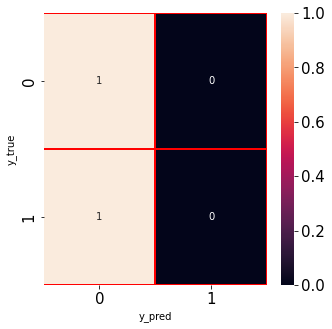

acc :  0.5
F1 Score:  0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6

LogReg


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


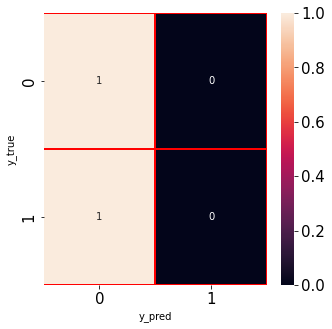

acc :  0.5
F1 Score:  0.3333333333333333
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         3
           1       0.00      0.00      0.00         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#--------
## Gauss:
#--------
print('Gauss')
y_pred_nb = nb.predict(x_test)
confusion(y_test,y_pred_nb)

print("acc : ",accuracy_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test ,y_pred_nb, average='macro'))
print(classification_report(y_test, y_pred_nb))

#-----------------------
## Regresión Logistica:
#-----------------------
print('LogReg')
y_pred_logreg = logreg.predict(x_test)
confusion(y_test,y_pred_logreg)

print("acc : ",accuracy_score(y_test, y_pred_logreg))
print("F1 Score: ", f1_score(y_test ,y_pred_logreg, average='macro'))
print(classification_report(y_test, y_pred_logreg))